<font size=7> Latencies Analysis

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist
from human_hip.animate import animate_latencies
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
with open("/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl", "rb") as filename:
    sd = pickle.load(filename)

In [3]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc

In [4]:
def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=15, sttc_cutoff = 0.04, latency_cutoff=1, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
        if abs(np.median(pair_latencies))> latency_cutoff and len(pair_latencies)>25:   
        #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
        #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
            #pairs_late.append( pair )  #lags_late.append( latency )
            if np.median(pair_latencies) < 0:
                pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
            else:
                pairs_late.append( pair ) 

    pairs= pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    ##Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs: 
        sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
        max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
        cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )   # if multiple maxima, take the one closest to zero
    cross_lag = np.array(cross_lag)
    to_keep = np.where((np.abs(cross_lag)< cross_sttc_max_cutoff) & (np.abs(cross_lag)> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")
    return np.array(pairs)[ to_keep ] 

#return np.array(pairs)



<font color="red"> We save curated latency pairs because above calculation took over 1 minute

In [80]:
#good_pairs = curate_latencies(sd)
good_pairs = curate_latencies(sd)
# with open( 'hc328_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
# load pickled data
# with open( 'hc328_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)

18496 Starting Pairs
567 pairs above sttc cutoff
78 pairs above latencency cutoff


In [81]:
#good_pairs
len(good_pairs)

78

In [82]:
plot_latency_angle_hist(sd, good_pairs)

TypeError: list indices must be integers or slices, not tuple

In [83]:
plot_latency_angle_hist(sd, good_pairs, by_firing_rate=True)

TypeError: list indices must be integers or slices, not tuple

# Vector plots

In [72]:
plot_vector_layout

<function human_hip.spike_data.plot_latencies.plot_vector_layout(sd, pairs, normalize=True, plot_neuron=True, arrow_length=75, min_dist=0, image_path=None, xlim=None, ylim=None, background_color='white')>

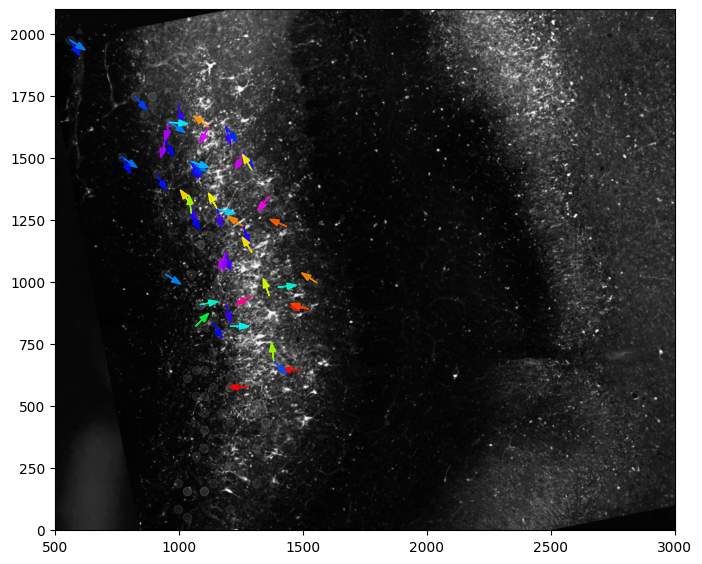

In [73]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc328_bw.jpeg", xlim=(500,3000) )

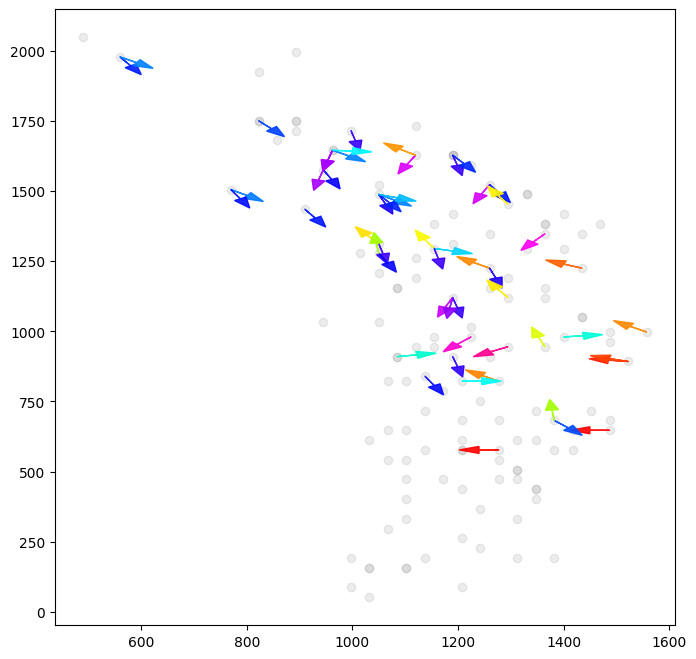

In [74]:
plot_vector_layout( sd, good_pairs)

In [75]:
def pairs_hisogram(pairs, sd, ms_cutoff_high=20):
    @interact
    def plot_pair(pair = (0, len(pairs)-1) ):
        latencies_pair = latencies( pairs[pair,0], pairs[pair,1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )

In [76]:
pairs_hisogram( good_pairs, sd, ms_cutoff_high=150)

interactive(children=(IntSlider(value=27, description='pair', max=54), Output()), _dom_classes=('widget-intera…